In [1]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
from scipy import integrate
import pandas as pd
from functools import partial
import models

the evolution of the $\frac{d\psi}{dt}$ can be written as the flux of probability $\psi$:

$$
\frac{d\psi}{dt}=\left[\frac{d\psi}{dt}\right]^{HD}+\left[\frac{d\psi}{dt}\right]^{IRD}+\left[\frac{d\psi}{dt}\right]^{Brownian}
$$

HD term (hydro term):
$$
\left[\frac{d\psi}{dt}\right]^{HD}=-\pmb{\nabla}_s\cdot(\pmb{\dot{p}}^{HD}\psi)
$$
IRD term (isotropic diffusion term):
$$
\left[\frac{d\psi}{dt}\right]^{IRD}=\pmb{\nabla}_s\cdot(\dot{\gamma}C_I\pmb{\nabla}_s\psi)
$$
Brownian term:
$$
\left[\frac{d\psi}{dt}\right]^{Brownian}=\pmb{\nabla}_s\cdot(D_r\pmb{\nabla}_s\psi)
$$
Tensor type of the FT model + Brownian:
$$
\dot{\pmb{A}}=\pmb{W\cdot A}-\pmb{A\cdot W}+\xi(\pmb{D\cdot A}+\pmb{A\cdot D}-2\pmb{A:D})+2C_I\dot \gamma(\pmb I-3\pmb{A})+2D_r(\pmb I-3\pmb A)
$$

# Function Definition

In [2]:
def da2_FT_Brownian_model(a2,L,CI,Dr,rho,a4_method='IBOF'):
    '''a2: the orientation tensor
    rho: the aspect ratio of the fiber
    L: the velocity gradient tensor
    CI: the interaction coefficient
    Dr: the Rotational Brownian Diffusion coefficient of the nano fiber
    a4_method: 'IBOF', 'ORW3'
    '''
    I=np.eye(3)
    D=0.5*(L+L.T)
    W=0.5*(L-L.T)
    if a4_method=='IBOF':
        a4=models.a4_IBOF.a4_IBOF(a2)
    elif a4_method=='ORW3':
        a4=models.a4_ORW3.a4_ORW3(a2)
    shear_rate=np.sqrt(np.tensordot(D,D,axes=([0,1],[1,0]))*2)
    da2=np.dot(W,a2)-np.dot(a2,W)+ \
            (rho**2-1)/(rho**2+1)*(np.dot(D,a2)+np.dot(a2,D)-2*np.tensordot(a4,D,axes=([2,3],[1,0])))+ \
            2*CI*shear_rate*(I-3*a2)+2*Dr*(I-3*a2)
    return da2
def da2_fun_for_ode(t,a2,CI,Dr,L,rho,a4_method='IBOF'):
    '''
    function for ode calculation
    a2 is the array with the shape like (9,)
    t is unused in this function
    rho: aspect ratio
    a2: 2 dimensional orientation tensor
    CI: interaction paramter,0.005<CI<0.05
    Dr: the Rotational Brownian Diffusion coefficient of the nano fiber
    a4_method: 'IBOF', 'ORW3'
    
    return: array with the shape of(9,)
    '''
    a2=a2.reshape((3,3))
    a2=(a2.T+a2)/2
    da2=da2_FT_Brownian_model(a2=a2,L=L,CI=CI,Dr=Dr,rho=rho,a4_method=a4_method)
    return da2.reshape((-1,))

# Three steps of the experiments:  
1. The sample was presheared at $\dot\gamma$ for time $t_1$;  
2. Then relax for time $t_2$, with the rotational diffusion coefficient of $D_r$;  
3. Lastly, reversal shear the sample under shear rate of $\dot\gamma$.

# 1. Preshear Step

<Axes: title={'center': 'Preshear'}, xlabel='time(s)'>

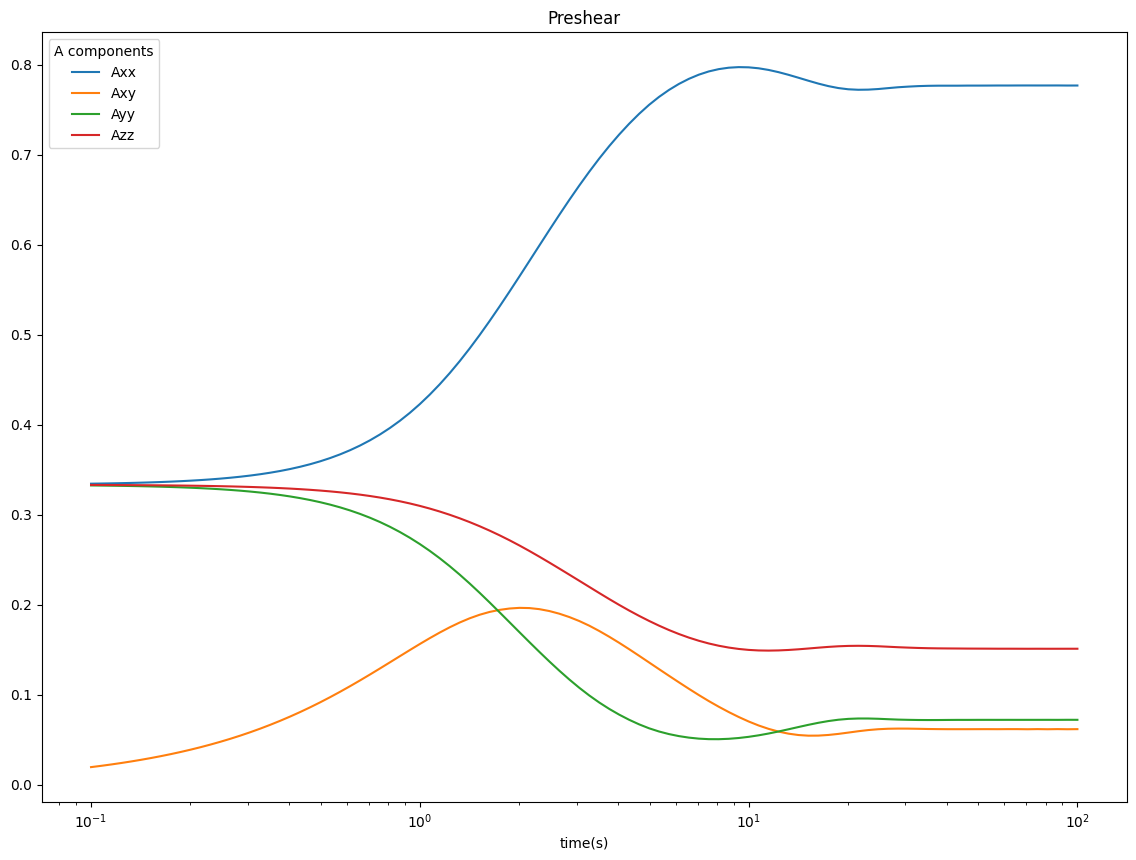

In [3]:
##################################################
#parameters
phi=0.038
CI=0.03*(1-np.exp(-0.224*33*phi))
#CI=0.0015
rho=11.2
Dr=2.3*10**-6
shear_rate=1
# preshear
L=np.zeros((3,3),dtype=np.float64)
L[0,1]=shear_rate
#for simple shear, initial state is random oriented
a2_0_pre=np.eye(3)/3
####################################################
#ode function
fun=partial(da2_fun_for_ode,CI=CI,Dr=Dr,L=L,rho=rho,a4_method='IBOF')
t_span=(0,100)# time span of the first step
t_eval=np.logspace(-1,np.log10(t_span[1]),num=100)
res_pre=integrate.solve_ivp(fun,t_span,a2_0_pre.reshape((-1,)),method='RK45',t_eval=t_eval)
pre_df=pd.DataFrame(res_pre.y.T,index=res_pre.t,columns=['Axx','Axy','Axz',\
                                                        'Ayx','Ayy','Ayz',\
                                                        'Azx','Azy','Azz'])
pre_df.index.name='time(s)'
pre_df.columns.name='A components'
#plot
pre_df.plot(y=['Axx','Axy','Ayy','Azz'],title='Preshear',figsize=(14,10),logx=True)

# 2. Relax Step

<Axes: title={'center': 'relax step'}, xlabel='time(s)'>

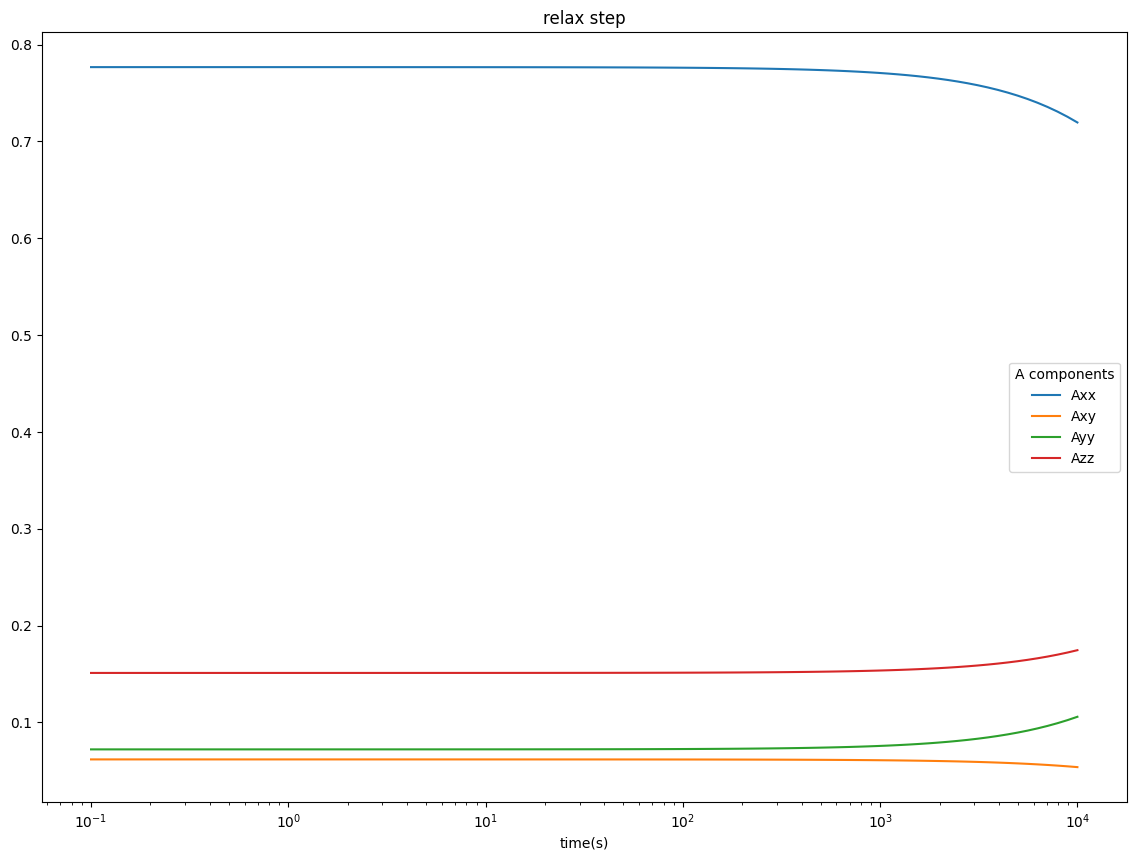

In [4]:
######################################
relax_time=10000#seconds
######################################
#the shear rate is zero in this step
L=np.zeros((3,3),dtype=np.float64)
#The initial state of A2 in this step
a2_0_relax=np.reshape(pre_df.iloc[-1,:].values,[3,3])
#ODE function
fun=partial(da2_fun_for_ode,CI=CI,Dr=Dr,L=L,rho=rho,a4_method='IBOF')
t_span=(0,relax_time)#time span of the second step
t_eval=np.logspace(-1,np.log10(t_span[1]),num=100)
res_relax=integrate.solve_ivp(fun,t_span,a2_0_relax.reshape((-1,)),method='RK45',t_eval=t_eval)
relax_df=pd.DataFrame(res_relax.y.T,index=res_relax.t,columns=['Axx','Axy','Axz',\
                                                                'Ayx','Ayy','Ayz',\
                                                                'Azx','Azy','Azz'])
relax_df.index.name='time(s)'
relax_df.columns.name='A components'
relax_df.plot(y=['Axx','Axy','Ayy','Azz'],title='relax step',figsize=(14,10),logx=True)

# Reversal Step

<Axes: title={'center': 'reversal shear'}, xlabel='time(s)'>

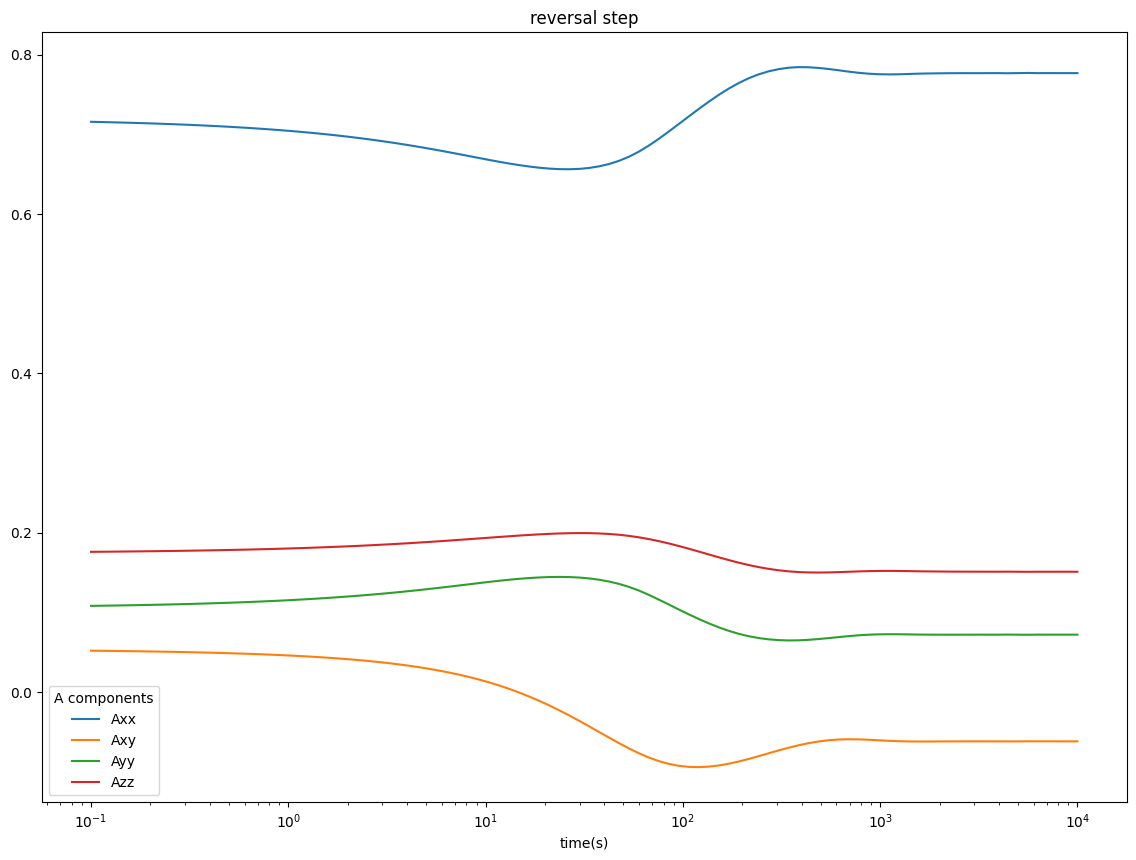

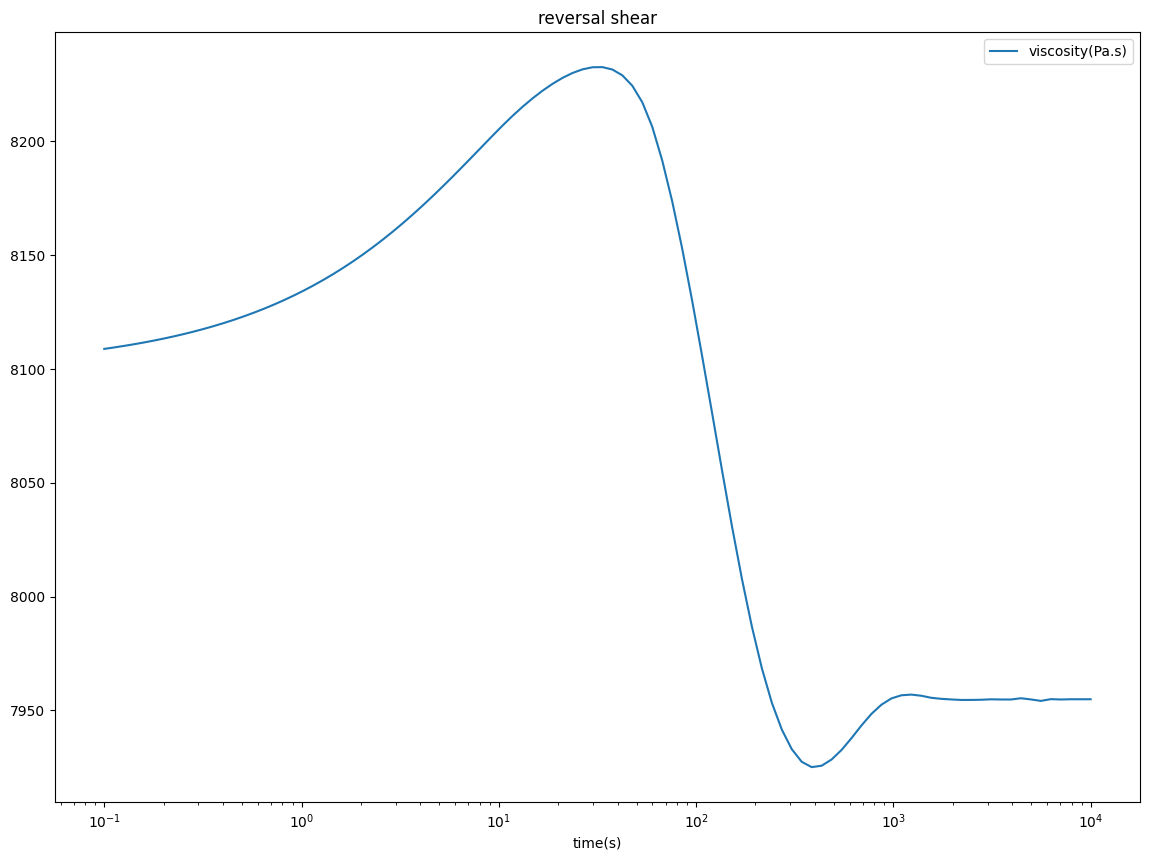

In [5]:
#reversal step
#the shear rate is reversal
L=np.zeros((3,3),dtype=np.float64)
L[0,1]=-shear_rate
#The initial state of A2 in this step
a2_0_rev=np.reshape(relax_df.iloc[-1,:].values,[3,3])
#ODE function
fun=partial(da2_fun_for_ode,CI=CI,Dr=Dr,L=L,rho=rho,a4_method='IBOF')
t_span=(0,100)#time span of the second step
t_eval=np.logspace(-1,np.log10(t_span[1]),num=100)
res_rev=integrate.solve_ivp(fun,t_span,a2_0_rev.reshape((-1,)),method='RK45',t_eval=t_eval)
rev_df=pd.DataFrame(res_rev.y.T,index=res_relax.t,columns=['Axx','Axy','Axz',\
                                                        'Ayx','Ayy','Ayz',\
                                                        'Azx','Azy','Azz'])
rev_df.index.name='time(s)'
rev_df.columns.name='A components'
rev_df.plot(y=['Axx','Axy','Ayy','Azz'],title='reversal step',figsize=(14,10),logx=True)

# stress by Lipscomb model

viscosity_0=7000
D=0.5*(L.T+L)
shear_rate=np.sqrt(np.tensordot(D,D,axes=([0,1],[1,0]))*2)
for ind,row in rev_df.iterrows():
    a2=np.reshape(row.values[:9],[3,3])
    #a4=models.a4_IBOF.a4_IBOF(a2)
    a4=models.a4_ORW3.a4_ORW3(a2)
    sigma=models.stress_Lipscomb.stress_Lipscomb(viscosity_0,L=L,rho=rho,a2=a2,phi=phi)
    rev_df.loc[ind,'viscosity(Pa.s)']=-sigma[0,1]/shear_rate
    rev_df.loc[ind,'N1(Pa)']=sigma[0,0]-sigma[1,1]
    rev_df.loc[ind,'N2(Pa)']=sigma[1,1]-sigma[2,2]
    rev_df.loc[ind,'N1-N2']=sigma[0,0]+sigma[2,2]-2*sigma[1,1]
    rev_df.loc[ind,'s11']=sigma[0,0]
    rev_df.loc[ind,'s12']=sigma[0,1]
    rev_df.loc[ind,'s13']=sigma[0,2]
    rev_df.loc[ind,'s22']=sigma[1,1]
    rev_df.loc[ind,'s23']=sigma[1,2]
    rev_df.loc[ind,'s33']=sigma[2,2]
rev_df.plot(y='viscosity(Pa.s)',title='reversal shear',figsize=(14,10),logx=True)